In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Data Cleaning

In [30]:
ivr_path = 'dataset/interactions/1'
ivr = pd.DataFrame()

for file_name in os.listdir(ivr_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(ivr_path, file_name)
        df = pd.read_csv(file_path)
        df.drop(columns=['source_id_char', 'dtl_5_num', 'dtl_5_char', 'dtl_6_num', 'dtl_6_char'], axis=1, inplace=True)
        df[['start_time', 'end_time', 'last_update_dt', 'dt']] = df[['start_time', 'end_time', 'last_update_dt', 'dt']].apply(pd.to_datetime)
        df[['category', 'product', 'lob', 'dtl_3_char']] = df[['category', 'product', 'lob', 'dtl_3_char']].astype('category')
        ivr = pd.concat([ivr, df], ignore_index=True)

# EDA

In [134]:
call_counts = ivr.groupby('dt').size().reset_index(name='Count')

call_counts['Count'].describe()

ts_df = ivr[ivr['category'] == 'TS']
# Group by date and count occurrences
ts_counts = ts_df.groupby('dt').size().reset_index(name='TS_Count')
ts_counts['TS_Count'].describe()

count       91.000000
mean     25945.879121
std       4956.143334
min      14626.000000
25%      23618.500000
50%      26924.000000
75%      28415.500000
max      43573.000000
Name: TS_Count, dtype: float64

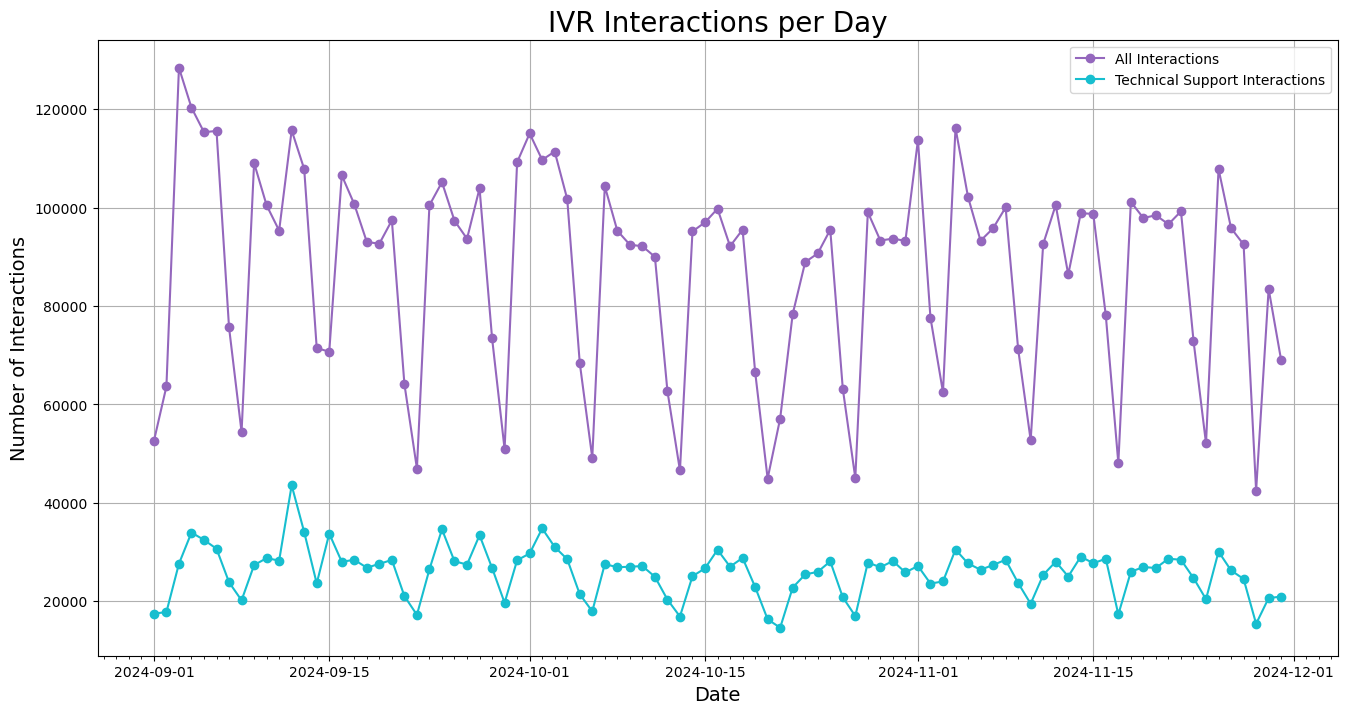

In [31]:
# Group by date and count occurrences
from matplotlib.dates import AutoDateLocator, DAILY



plt.figure(figsize=(16, 8))
plt.plot(call_counts['dt'], call_counts['Count'], marker='o', linestyle='-', color='C4', label='All Interactions')
plt.plot(ts_counts['dt'], ts_counts['TS_Count'], marker='o', linestyle='-', color='C9', label='Technical Support Interactions')
plt.legend()
plt.title("IVR Interactions per Day",fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Interactions", fontsize=14)
plt.grid(True)

ax = plt.gca()
locator = AutoDateLocator()
locator.intervald[DAILY] = [1]
ax.xaxis.set_minor_locator(locator)
plt.xticks()
# plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

Date with maximum TS count: 2024-09-12 00:00:00, Count: 43573


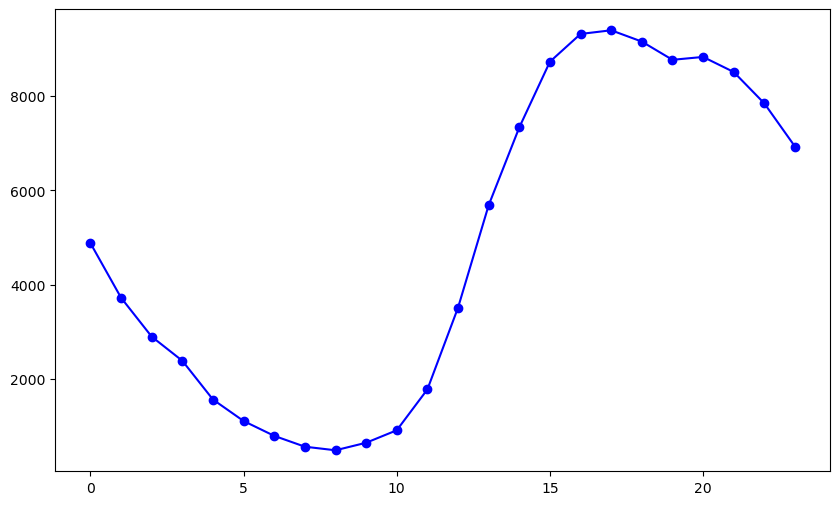

In [32]:
# Find the row with the maximum TS_Count
max_ts_row = ts_counts.loc[ts_counts['TS_Count'].idxmax()]

# Extract the date and count
max_ts_date = max_ts_row['dt']
max_ts_count = max_ts_row['TS_Count']

print(f"Date with maximum TS count: {max_ts_date}, Count: {max_ts_count}")

sept12 = ivr[ivr['dt'] == max_ts_date]
# print(sept12.head(5))
times = pd.DatetimeIndex(sept12.start_time)
sept12_counts = sept12.groupby([times.hour]).size().reset_index(name='Count')
# print(sept12_counts)

plt.figure(figsize=(10, 6))
plt.plot(sept12_counts['start_time'], sept12_counts['Count'], marker='o', linestyle='-', color='b')

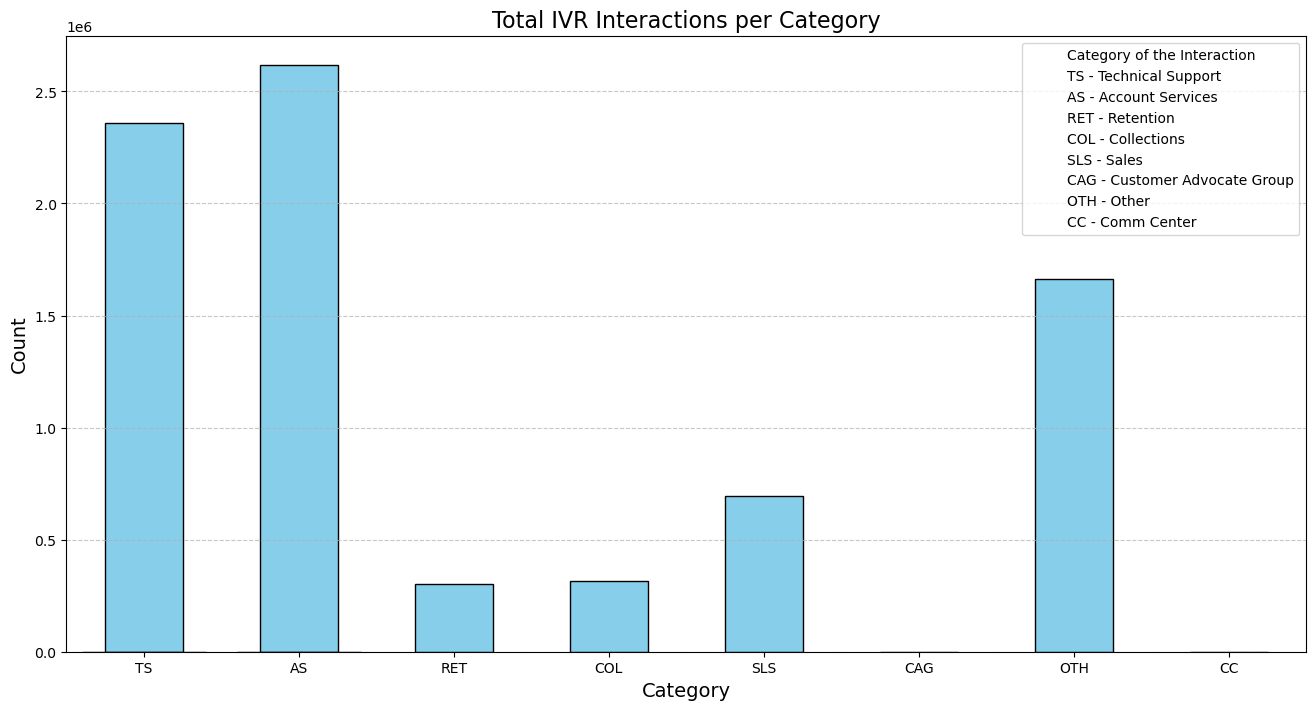

In [33]:
# Plot histogram of all categories

legend_labels = [
    "TS - Technical Support",
    "AS - Account Services",
    "RET - Retention",
    "COL - Collections",
    "SLS - Sales",
    "CAG - Customer Advocate Group",
    "OTH - Other",
    "CC - Comm Center"
]
all_categories = ["TS", "AS", "RET", "COL", "SLS", "CAG", "OTH", "CC"]

plt.figure(figsize=(16, 8))
category_counts = ivr['category'].value_counts()
category_counts = category_counts.reindex(all_categories)

category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.bar("CAG", 0, color='skyblue', edgecolor='black')
plt.bar("CC", 0, color='skyblue', edgecolor='black')

handles = [plt.Line2D([0], [0], color='none', lw=0)] * len(legend_labels)
plt.title("Total IVR Interactions per Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(handles, legend_labels, title="Category of the Interaction", loc="upper right")
plt.show()

# Model Creation

In [35]:
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

In [127]:
ivr_4hour = ivr.copy()
ivr_4hour['interval'] = ivr_4hour['start_time'].dt.floor('4h')
ivr_4hour = ivr_4hour.groupby('interval').size().reset_index(name='Count')

scaler = MinMaxScaler()

data = ivr_4hour[['Count']].values
scaled_data = scaler.fit_transform(data)

In [128]:
# Prepare sequences for the autoencoder (e.g., using sliding window approach)
sequence_length = 10  # Number of past time steps to use for encoding

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

X = create_sequences(scaled_data, sequence_length)
X = torch.tensor(X, dtype=torch.float32)

In [124]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(sequence_length, 5),
            nn.ReLU(),
            nn.Linear(5, 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, sequence_length),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [129]:
# Define the model, loss function, and optimizer
# Input dimension is the length of the sequence
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5360x1 and 10x5)

In [94]:
import torch.nn.functional as F

def calculate_reconstruction_error(original, reconstructed):
    # Compute MSE between original and reconstructed
    # average error per sequence
    return F.mse_loss(reconstructed, original, reduction='none').mean(dim=(1, 2))

In [95]:
# Set the model to evaluation mode
model.eval()

# Pass the test data through the autoencoder
with torch.no_grad():
    reconstructed = model(X)  # Output from the decoder

    # Calculate reconstruction error
    errors = calculate_reconstruction_error(X, reconstructed)

    # Print the errors
    print(errors)

tensor([0.0228, 0.0052, 0.0108, 0.0248, 0.0092, 0.0088, 0.0137, 0.0031, 0.0044,
        0.0146, 0.0038, 0.0062, 0.0176, 0.0038, 0.0089, 0.0184, 0.0074, 0.0098,
        0.0218, 0.0037, 0.0080, 0.0161, 0.0196, 0.0033, 0.0127, 0.0069, 0.0042,
        0.0065, 0.0066, 0.0064, 0.0080, 0.0066, 0.0025, 0.0043, 0.0063, 0.0132,
        0.0341, 0.0066, 0.0186, 0.0297, 0.0098, 0.0091, 0.0254, 0.0057, 0.0122,
        0.0198, 0.0071, 0.0090, 0.0231, 0.0047, 0.0104, 0.0210, 0.0081, 0.0082,
        0.0190, 0.0038, 0.0079, 0.0190, 0.0069, 0.0082, 0.0211, 0.0040, 0.0108,
        0.0208, 0.0078, 0.0043, 0.0128, 0.0046, 0.0038, 0.0095, 0.0067, 0.0061,
        0.0090, 0.0082, 0.0023, 0.0045, 0.0059, 0.0138, 0.0439, 0.0095, 0.0258,
        0.0322, 0.0104, 0.0085, 0.0222, 0.0046, 0.0104, 0.0182, 0.0066, 0.0075,
        0.0217, 0.0049, 0.0104, 0.0181, 0.0072, 0.0056, 0.0069, 0.0060, 0.0017,
        0.0053, 0.0087, 0.0103, 0.0237, 0.0056, 0.0126, 0.0180, 0.0069, 0.0052,
        0.0138])


In [82]:
# Set a threshold for anomaly detection (e.g., 95th percentile of reconstruction errors)
threshold = torch.quantile(errors, 0.95)

# Identify anomalies
anomalies = errors > threshold

# Print the anomaly indices and corresponding errors
anomaly_indices = torch.nonzero(anomalies).squeeze()
print(f"Anomalies detected at indices: {anomaly_indices}")

Anomalies detected at indices: tensor([55, 73, 79, 85, 97])


In [85]:
time_intervals = ivr_4hour['interval'].values
# print(time_intervals)

ValueError: x and y must have same first dimension, but have shapes (546,) and (100,)

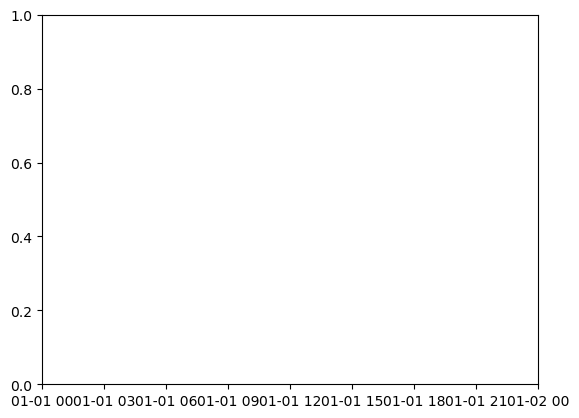

In [87]:
from matplotlib.dates import DateFormatter

plt.plot(time_intervals, errors.numpy())
plt.axhline(y=threshold.numpy(), color='r', linestyle='--', label='Threshold')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))

plt.xlabel('Test Samples')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# Code below is not being used

In [4]:
wo_path = 'dataset/interactions/4'
wo = pd.DataFrame()

for file_name in os.listdir(wo_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(wo_path, file_name)
        df = pd.read_csv(file_path)
        df.drop(columns=['source_id_char', 'dtl_6_num'], axis=1, inplace=True)
        df[['start_time', 'end_time', 
           'last_update_dt', 'dt']] = df[['start_time', 'end_time', 'last_update_dt', 'dt']].apply(pd.to_datetime)
        
        wo = pd.concat([wo, df], ignore_index=True)

In [38]:
wo.head()
wo.dtypes
wo.memory_usage(deep=True)

Index                         128
site_id                  29286088
account_nbr              29286088
customer_key             29286088
start_time               29286088
end_time                 29286088
transaction_id          261052480
category                215984899
product                 213678196
lob                     212324138
source_id_num            29286088
dtl_1_num                29286088
dtl_1_char              276757960
dtl_2_num                29286088
dtl_2_char              215962900
dtl_3_num                29286088
dtl_3_char              215984899
dtl_4_num                29286088
dtl_4_char              248020312
dtl_5_num                29286088
dtl_5_char              251238755
dtl_6_char              235655908
last_update_dt           29286088
interaction_type_key     29286088
dt                       29286088
dtype: int64

In [ ]:
outinv_path = 'dataset/interactions/6'
outinv = pd.DataFrame()

for file_name in os.listdir(outinv_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(outinv_path, file_name)
        df = pd.read_csv(file_path)
        df.drop(columns=['source_id_num', 'dtl_4_num', 'dtl_5_num', 'dtl_6_num'], axis=1, inplace=True)
        df[['start_time', 'end_time', 'last_update_dt', 'dt']] = df[['start_time',
                                                                     'end_time', 'last_update_dt', 'dt']].apply(pd.to_datetime)

        df[['category', 'product', 'lob', 'dtl_2_char', 'dtl_3_char']] = df[['category', 'product', 'lob', 
                                                                             'dtl_2_char','dtl_3_char']].astype('category')
        outinv = pd.concat([outinv, df], ignore_index=True)

In [ ]:
outinv.head(10)